# Intrusion Detection System Using Machine Learning



### Version Check

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

0.23.4
1.15.4
3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
0.20.1


# 1. Data import

In [46]:
import  pandas  as  pd 
import  numpy  as  np
import warnings
warnings.filterwarnings('ignore')
LOCAL_IP = '192.168.0.1'
IF_CONTAMINATION = '0.01'

df  =  pd . read_csv ( 'sa3.csv' ) 
df . columns  =  [ 'no' ,  'time' , 'ipsrc' ,  'ipdst' ,  'proto' ,  'len', 'info' ] 
#df  ['time'] = pd.to_datetime(df['time'])
# The column [count] with value 1 is added to then make the additions. 
df['info'] = "null"
#df.parse_dates=["time"]
df['time'] = pd.to_datetime(df['time'])
df['count']=1


In [47]:
df . head (5)

,no,time,ipsrc,ipdst,proto,len,info,count
0,1,2017-03-22 15:30:30,192.168.60.6,192.168.100.1,SSH,2962,null,1
1,2,2017-03-22 15:30:30,192.168.100.1,192.168.60.6,TCP,66,null,1
2,3,2017-03-22 15:30:30,192.168.60.6,192.168.100.1,SSH,2962,null,1
3,4,2017-03-22 15:30:30,192.168.60.6,192.168.100.1,SSH,2962,null,1
4,5,2017-03-22 15:30:30,192.168.100.1,192.168.60.6,TCP,66,null,1


# 2 Data Grouping

In [48]:
# The grouping is done by [ipdst] and [proto], a .resample of [time] in 5 seconds and the sum is made. 
# It also resets the index and drops the NaN values. 
dataGroup2 = df.groupby(['ipsrc','proto']).resample('5S', on= "time").sum().reset_index().dropna()
pd.options.display.float_format = '{:,.0f}'.format
# Drop row with IP
local_ip="192.168.100.1"
dataGroup2 = dataGroup2[['ipsrc','proto','time','count']]
dataGroup2 = dataGroup2[dataGroup2.ipsrc != local_ip]
dataGroup2.head(5)

,ipsrc,proto,time,count
14,192.168.60.6,SSH,2017-03-22 15:30:30,2222
15,192.168.60.6,SSH,2017-03-22 15:30:35,3168
16,192.168.60.6,SSH,2017-03-22 15:30:40,3324
17,192.168.60.6,SSH,2017-03-22 15:30:45,3026
18,192.168.60.6,SSH,2017-03-22 15:30:50,3089


## 3 Data Normalization

In [49]:
dataNorm = dataGroup2.copy()
dataNorm['count_n'] = (dataGroup2['count'] - dataGroup2['count'].min()) / (dataGroup2['count'].max() - dataGroup2['count'].min())
dataNorm.head(5)

,ipsrc,proto,time,count,count_n
14,192.168.60.6,SSH,2017-03-22 15:30:30,2222,1
15,192.168.60.6,SSH,2017-03-22 15:30:35,3168,1
16,192.168.60.6,SSH,2017-03-22 15:30:40,3324,1
17,192.168.60.6,SSH,2017-03-22 15:30:45,3026,1
18,192.168.60.6,SSH,2017-03-22 15:30:50,3089,1


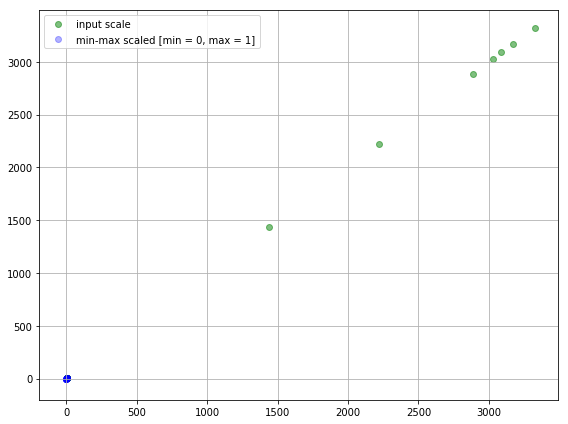

In [50]:
%matplotlib inline

from  matplotlib  import  pyplot  as  plt

def  plot (): 
    plt . figure ( figsize = ( 8 , 6 ))

    plt . scatter ( dataGroup2 [ 'count' ],  dataGroup2 [ 'count' ], 
            color = 'green' ,  label = 'input scale' ,  alpha = 0.5 )
        
    plt . scatter ( dataNorm [ 'count_n' ],  dataNorm [ 'count_n' ], 
            color = 'blue' ,  label = 'min-max scaled [min = 0, max = 1]' ,  alpha = 0.3 )
    
    plt . legend ( loc = 'upper left' ) 
    plt . grid ()

    plt . tight_layout ()

plot () 
plt . show ()

### 3.1 Vanilla Python 

In [51]:
# Standardization
x  =  dataGroup2 [ 'count' ] 
mean  =  sum ( x ) / len ( x ) 
std_dev  =  ( 1 / len ( x )  *  sum ([  ( x_i  -  mean ) ** 2  for  x_i  in  x ])) ** 0.5

z_scores  =  [( x_i  -  mean ) / std_dev  for  x_i  in  x ] 
print ( z_scores ) 
# Min-Max scaling

minmax  =  [( x_i  -  min ( x ))  /  ( max ( x )  -  min ( x ))  for  x_i  in  x ] 
print ( minmax )

[0.6604255952577407, 1.32276492642654, 1.4319879028137839, 1.2233440120227668, 1.2674532909483844, 1.1274238340416616, 0.10940968232978614, -0.8932012291223498, -0.8925010818378162, -0.8911007872687489, -0.8932012291223498, -0.8911007872687489, -0.8925010818378162, -0.894601523691417, -0.894601523691417]
[0.6683719530544688, 0.9530544688534457, 1.0, 0.9103219981944026, 0.9292807703882034, 0.8690941919951851, 0.4315377670779416, 0.0006018657839301836, 0.0009027986758952753, 0.001504664459825459, 0.0006018657839301836, 0.001504664459825459, 0.0009027986758952753, 0.0, 0.0]


### 3.2 NumPy

In [52]:
import  numpy  as  np

# Standardization

x_np  =  np . asarray ( x ) 
z_scores_np  =  ( x_np  -  x_np . mean ())  /  x_np . std () 
print ( z_scores_np )

# Min-Max scaling

np_minmax  =  ( x_np  -  x_np . min ())  /  ( x_np . max ()  -  x_np . min ()) 
print ( np_minmax )

[ 0.6604256   1.32276493  1.4319879   1.22334401  1.26745329  1.12742383
  0.10940968 -0.89320123 -0.89250108 -0.89110079 -0.89320123 -0.89110079
 -0.89250108 -0.89460152 -0.89460152]
[6.68371953e-01 9.53054469e-01 1.00000000e+00 9.10321998e-01
 9.29280770e-01 8.69094192e-01 4.31537767e-01 6.01865784e-04
 9.02798676e-04 1.50466446e-03 6.01865784e-04 1.50466446e-03
 9.02798676e-04 0.00000000e+00 0.00000000e+00]


### 3.3 Visualization 

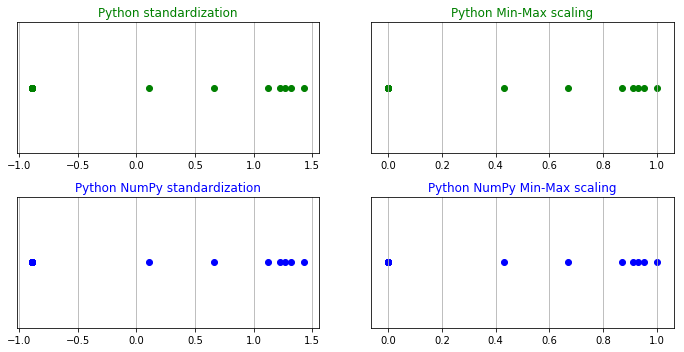

In [53]:
from  matplotlib  import  pyplot  as  plt
x  =  dataGroup2 [ 'count' ] 



fig ,  (( ax1 ,  ax2 ),  ( ax3 ,  ax4 ))  =  plt . subplots ( nrows = 2 ,  ncols = 2 ,  figsize = ( 10 , 5 ))

y_pos  =  [ 0  for  i  in  range ( len ( x ))]

ax1 . scatter ( z_scores ,  y_pos ,  color = 'g' ) 
ax1 . set_title ( 'Python standardization' ,  color = 'g' )

ax2 . scatter ( minmax ,  y_pos ,  color = 'g' ) 
ax2 . set_title ( 'Python Min-Max scaling' ,  color = 'g' )

ax3 . scatter ( z_scores_np ,  y_pos ,  color = 'b' ) 
ax3 . set_title ( 'Python NumPy standardization' ,  color = 'b' )

ax4 . scatter ( np_minmax ,  y_pos ,  color = 'b' ) 
ax4 . set_title ( 'Python NumPy Min-Max scaling' ,  color = 'b' )

plt . tight_layout ()

for  x  in  ( ax1 ,  ax2 ,  ax3 ,  ax4 ): 
    x . get_yaxis () . set_visible ( False ) 
    x . grid ()

plt . show ()

### 4. Isolation Forest

In [54]:
from  sklearn.pipeline  import  Pipeline 
from  sklearn.ensemble  import  IsolationForest

dataNorm  =  dataNorm [[ 'count' , 'count_n' ]]

# The iloc function allows us to select from one position to another in an array. 
dataTrain  =  dataNorm . iloc [ 0 : 5 ]

clf  =  IsolationForest ( n_estimators = 100 ,  contamination = 0.00001 ,  max_samples = 5 ) 

##train Machine
 
clf.behaviour="new"
clf.fit ( dataTrain )
##Predications
prediction  =  clf . predict ( dataNorm )
dataGroup2 [ 'prediction' ]  =  prediction 
dataGroup2 [[ 'count' , 'prediction' ]]

,count,prediction
14,2222,-1
15,3168,1
16,3324,1
17,3026,1
18,3089,1
19,2889,1
20,1435,-1
21,3,-1
22,4,-1
23,6,-1


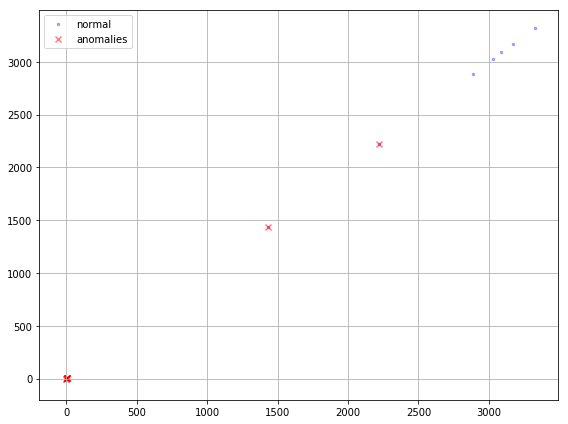

In [55]:
x  =  dataGroup2 [( dataGroup2 [ 'prediction' ]  ==  - 1 )] [ 'count' ] . values

%matplotlib inline

from  matplotlib  import  pyplot  as  plt

def  plot (): 
    plt . figure ( figsize = ( 8 , 6 ))

    plt . scatter ( dataGroup2 [ 'count' ],  dataGroup2 [ 'count' ],  s = 6 ,  label = "normal" ,  alpha = 0.3 ,  color = "blue" )
        
    plt . scatter ( x ,  x ,  marker = "x" ,  color = "red" ,  label = "anomalies" ,  alpha = 0.5 )
    
    plt . legend ( loc = 'upper left' ) 
    plt . grid ()

    plt . tight_layout ()

plot () 
plt . show ()

### 4.1 Plot Isolation Forest 

In [56]:
import  numpy  as  np ,  matplotlib.pyplot  as  plt 
from  matplotlib.colors  import  ListedColormap

def  plot_decision ( X ,  y ,  classifier ,  test_idx = None ,  resolution = 0.02 ,  figsize = ( 6 , 6 )):

    # setup marker generator and color map 
    markers  =  ( 's' ,  ' x ' ,  ' o ' ,  ' ^ ' ,  ' v ' ) 
    colors=["red", "orange", "gold", "limegreen", "blue", "purple", "seagreen"]

    cmap  =  ListedColormap ( colors)
    
    # get dimensions 
    x1_min ,  x1_max  =  X [:,  0 ] . min ()  -  1 ,  X [:,  0 ] . max ()  +  1 
    x2_min ,  x2_max  =  X [:,  1 ] . min ()  -  1 ,  X [:,  1 ] . max ()  +  1 
    xx1 ,  xx2  =  np . meshgrid ( np. arange ( x1_min ,  x1_max ,  resolution ),  np . arange ( x2_min ,  x2_max ,  resolution )) 
    xmin  =  xx1 . min () 
    xmax  =  xx1 . max () 
    ymin  =  xx2 . min () 
    ymax  =  xx2 . max ()
    
    # create the figure 
    fig ,  ax  =  plt . subplots ( figsize = figsize ) 
    ax . set_xlim ( xmin ,  xmax ) 
    ax . set_ylim ( ymin ,  ymax )
    
    # plot the decision surface 
    Z  =  classifier . predict ( np . array ([ xx1 . ravel (),  xx2 . ravel ()]) . T ) 
    Z  =  Z . reshape ( xx1 . shape ) 
    ax . contourf ( xx1 ,  xx2 ,  Z ,  alpha = 0.4 ,  cmap = cmap ,  zorder = 1)
    
    # plot all samples 
    for  idx ,  cl  in  enumerate ( np . unique ( y )): 
        ax . scatter ( x = X [ y  ==  cl ,  0 ],  
                   y = X [ y  ==  cl ,  1 ], 
                   alpha = 0.6 ,  
                   c = cmap ( idx ), 
                   edgecolor = 'black' , 
                   marker = 'o', #markers [idx], 
                   s = 50 , 
                   label = cl , 
                   zorder = 3 )

    # Highlight test samples 
    if  test_idx : 
        X_test ,  y_test  =  X [ test_idx ,  :], [ test_idx ] 
        ax . scatter ( X_test [:,  0 ], 
                   X_test [:,  1 ], 
                   c = 'w' , 
                   alpha = 1.0 , 
                   edgecolor = 'black' , 
                   linewidths = 1 , 
                   marker = 'o' , 
                   s = 150,  
                   label = 'test set' , 
                   zorder = 2 )
        
dataGroup2 [ 'idpst_label' ],  _  =  pd . factorize ( dataGroup2 [ 'ipsrc' ]) 
dataGroup2

,ipsrc,proto,time,count,prediction,idpst_label
14,192.168.60.6,SSH,2017-03-22 15:30:30,2222,-1,0
15,192.168.60.6,SSH,2017-03-22 15:30:35,3168,1,0
16,192.168.60.6,SSH,2017-03-22 15:30:40,3324,1,0
17,192.168.60.6,SSH,2017-03-22 15:30:45,3026,1,0
18,192.168.60.6,SSH,2017-03-22 15:30:50,3089,1,0
19,192.168.60.6,SSH,2017-03-22 15:30:55,2889,1,0
20,192.168.60.6,SSH,2017-03-22 15:31:00,1435,-1,0
21,192.168.60.6,TCP,2017-03-22 15:30:30,3,-1,0
22,192.168.60.6,TCP,2017-03-22 15:30:35,4,-1,0
23,192.168.60.6,TCP,2017-03-22 15:30:40,6,-1,0


Misclassified samples: 1 
Accuracy:  0.80 


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


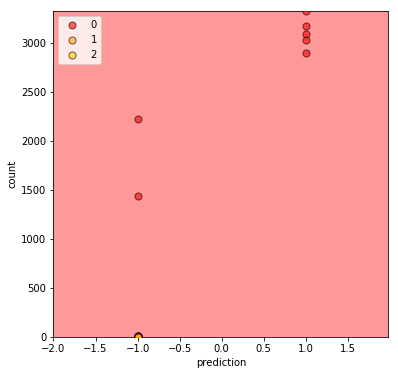

In [57]:
import  numpy  as  np ,  pandas  as  pd ,  matplotlib.pyplot  as  plt ,  pydotplus 
from  sklearn  import  tree ,  metrics ,  model_selection ,  preprocessing 
from  IPython.display  import  Image ,  display

dataGroup2 [ 'idpst_label' ],  _  =  pd . factorize ( dataGroup2 [ 'ipsrc' ])

y  =  dataGroup2 [ 'idpst_label' ] 
X  =  dataGroup2 [[ 'prediction' ,  'count' ]]

# split data randomly into 70% training and 30% test 
X_train ,  X_test ,  y_train ,  y_test  =  model_selection . train_test_split ( X ,  y ,  test_size = 0.3 ,  random_state = 0 )

# train the decision tree 
dtree  =  tree . DecisionTreeClassifier ( criterion = 'entropy' ,  max_depth = 3 ,  random_state = 0 ) 
dtree . fit ( X_train ,  y_train )

# use the model to make predictions with the test data 
y_pred  =  dtree . predict ( X_test )

# how did our model perform? 
count_misclassified  =  ( y_test !=  y_pred ) . sum () 
print ( 'Misclassified samples: {} ' . format ( count_misclassified )) 
accuracy  =  metrics . accuracy_score ( y_test ,  y_pred ) 
print ( 'Accuracy: {: .2f} ' . format ( accuracy ))

# visualize the model's decision regions to see how it separates the samples 
X_combined  =  np . vstack (( X_train ,  X_test )) 
y_combined  =  np . hstack (( y_train ,  y_test )) 
plot_decision ( X = X_combined , y=y_combined  ,  classifier = dtree ) 
plt . xlabel ( 'prediction' ) 
plt . ylabel ( 'count') 
plt . legend ( loc = 'upper left' ) 
plt . show ()

# We only have one IP.

In [58]:
import  plotly.plotly  as  py 
from  plotly  import  __version__ 
from  plotly.offline  import  download_plotlyjs ,  init_notebook_mode ,  plot ,  iplot 
from  plotly.graph_objs  import  Scatter ,  Figure ,  Layout 
init_notebook_mode ( connected = True )

import  plotly.offline  as  offline 
import  plotly.graph_objs  as  go 
from  plotly.graph_objs  import  *



## 5.1 Unordered Timings 


In [59]:
dataGroup2

,ipsrc,proto,time,count,prediction,idpst_label
14,192.168.60.6,SSH,2017-03-22 15:30:30,2222,-1,0
15,192.168.60.6,SSH,2017-03-22 15:30:35,3168,1,0
16,192.168.60.6,SSH,2017-03-22 15:30:40,3324,1,0
17,192.168.60.6,SSH,2017-03-22 15:30:45,3026,1,0
18,192.168.60.6,SSH,2017-03-22 15:30:50,3089,1,0
19,192.168.60.6,SSH,2017-03-22 15:30:55,2889,1,0
20,192.168.60.6,SSH,2017-03-22 15:31:00,1435,-1,0
21,192.168.60.6,TCP,2017-03-22 15:30:30,3,-1,0
22,192.168.60.6,TCP,2017-03-22 15:30:35,4,-1,0
23,192.168.60.6,TCP,2017-03-22 15:30:40,6,-1,0


In [60]:
#Normal Traffic 
nor  =  dataGroup2 [( dataGroup2 [ 'prediction' ]  ==  1 )] [ 'count' ] 
#Anomalies 
ano  =  dataGroup2 [( dataGroup2 [ 'prediction' ]  ==  - 1 )] [ 'count' ]


normal  =  go . Scatter ( 
    x  =  dataGroup2 [( dataGroup2 [ 'prediction' ]  ==  1 )] [ 'time' ], 
    y  =  nor , 
    mode  =  "lines + markers" , 
    name  =  "Normal Traffic" 
)


anomalies  =  dict ( 
    x = dataGroup2 [( dataGroup2 [ 'prediction' ]  ==  - 1 )] [ 'time' ], 
    y =  ano, 
    name  =  "Anomalies" , 
    mode  =  'markers' , 
    
    marker = Marker ( 
            size = 7 , 
            symbol =  "circle" , 
            color = 'rgb (255, 0, 0)' 
        ), 
    opacity  =  0.8 )

data  =  [ normal ,  anomalies ]

layout  =  dict ( 
    title = 'Total requests by time' , 
    xaxis = dict ( 
        title  =  'Date' , 
       rangeslider = dict (), 
        type = 'date' 
    ), 
    yaxis = dict ( 
        title  =  'No. packets' 
    ), 
    legend = dict ( 
        x = 0 , 
        y = 1 , 
        traceorder = 'normal' , 
        font = dict( 
            family = 'sans-serif' , 
            size = 12 , 
            color = '# 000' 
        ), 
        bgcolor = '# E2E2E2' , 
        bordercolor = '#FFFFFF' , 
        borderwidth = 2 
    )  
)

fig  =  dict ( data=data  ,  layout = layout ) 
iplot ( fig ,  filename  =  "Total requests per time" )



### 5.2 Ordering Times

In [63]:
dataGroup3  =  dataGroup2 . sort_values ( by = [ 'time' ]) 
dataGroup3


,ipsrc,proto,time,count,prediction,idpst_label
14,192.168.60.6,SSH,2017-03-22 15:30:30,2222,-1,0
21,192.168.60.6,TCP,2017-03-22 15:30:30,3,-1,0
15,192.168.60.6,SSH,2017-03-22 15:30:35,3168,1,0
22,192.168.60.6,TCP,2017-03-22 15:30:35,4,-1,0
16,192.168.60.6,SSH,2017-03-22 15:30:40,3324,1,0
23,192.168.60.6,TCP,2017-03-22 15:30:40,6,-1,0
27,fa:16:3e:66:6e:87,ARP,2017-03-22 15:30:40,1,-1,1
28,fa:16:3e:f2:5a:f7,ARP,2017-03-22 15:30:40,1,-1,2
17,192.168.60.6,SSH,2017-03-22 15:30:45,3026,1,0
24,192.168.60.6,TCP,2017-03-22 15:30:45,3,-1,0


In [64]:
#Normal Traffic 
nor  =  dataGroup3 [( dataGroup2 [ 'prediction' ]  ==  1 )] [ 'count' ] 
#Anomalies 
ano  =  dataGroup3 [( dataGroup2 [ 'prediction' ]  ==  - 1 )] [ 'count' ]


normal  =  go . Scatter ( 
    x  =  dataGroup3 [( dataGroup2 [ 'prediction' ]  ==  1 )] [ 'time' ], 
    y  =  nor , 
    mode  =  "lines + markers" , 
    name  =  "Normal Traffic" 
)


anomalies  =  dict ( 
    x = dataGroup3 [( dataGroup2 [ 'prediction' ]  ==  - 1 )] [ 'time' ], 
    y =  ano, 
    name  =  "Anomalies" , 
    mode  =  'markers' , 
    
    marker = Marker ( 
            size = 7 , 
            symbol =  "circle" , 
            color = 'rgb (255, 0, 0)' 
        ), 
    opacity  =  0.8 )

data  =  [ normal ,  anomalies ]

layout  =  dict ( 
    title = 'Total requests by time' , 
    xaxis = dict ( 
       title  =  'Date' , 
       rangeslider = dict (), 
        type = 'date' 
    ), 
    yaxis = dict ( 
        title  =  'No. packets' 
    ), 
    legend = dict ( 
        x = 0 , 
        y = 1 , 
        traceorder = 'normal' , 
        font = dict( 
            family = 'sans-serif' , 
            size = 12 , 
            color = '# 000' 
        ), 
        bgcolor = '# E2E2E2' , 
        bordercolor = '#FFFFFF' , 
        borderwidth = 2 
    )  
)

fig  =  dict ( data=data  ,  layout = layout ) 
iplot ( fig ,  filename  =  "Total requests per time" )



In [65]:
dataGroup4  =  dataGroup2 . groupby ([ 'time' ]) . sum () . reset_index () . dropna () 
dataGroup4

,time,count,prediction,idpst_label
0,2017-03-22 15:30:30,2225,-2,0
1,2017-03-22 15:30:35,3172,0,0
2,2017-03-22 15:30:40,3332,-2,3
3,2017-03-22 15:30:45,3029,0,0
4,2017-03-22 15:30:50,3095,0,0
5,2017-03-22 15:30:55,2893,0,0
6,2017-03-22 15:31:00,1435,-1,0


In [66]:
#Normal Traffic 
nor  =  dataGroup4 [( dataGroup4 [ 'prediction' ]  ==  1 )] [ 'count' ] 
#Anomalies 
ano  =  dataGroup4 [( dataGroup4 [ 'prediction' ]  ==  - 1 )] [ 'count' ]


normal  =  go . Scatter ( 
    x  =  dataGroup4 [( dataGroup4 [ 'prediction' ]  ==  1 )] [ 'time' ], 
    y  =  nor , 
    mode  =  "lines + markers" , 
    name  =  "Normal Traffic" 
)


anomalies  =  dict ( 
    x = dataGroup4 [( dataGroup4 [ 'prediction' ]  ==  - 1 )] [ 'time' ], 
    y = ano , 
    name  =  "Anomalies" , 
    mode  =  'markers' , 
    marker = Marker ( 
            size = 7 , 
            symbol =  "circle" , 
            color = 'rgb (255, 0, 0)' 
        ), 
    opacity  =  0.8 )

data  =  [ normal ,  anomalies ]

layout  =  dict ( 
    title = 'Total requests by time' , 
    xaxis = dict ( 
        title  =  'Date' , 
        rangeslider = dict (), 
        type = 'date' 
    ), 
    yaxis = dict ( 
        title  =  'No. packets' 
    ), 
    legend = dict ( 
        x = 0 , 
        y = 1 , 
        traceorder = 'normal' , 
        font = dict (
            family = 'sans-serif' , 
            size = 12 , 
            color = '# 000'
         ), 
        bgcolor = '# E2E2E2' , 
        bordercolor = '#FFFFFF' , 
        borderwidth = 2 
    )  
)

fig  =  dict ( data = data ,  layout = layout ) 
iplot ( fig ,  filename  =  "Total requests per time" )


### 6. Map anomalies

In [80]:
import  re 
import  json 
import urllib.request, json
import  plotly.plotly  as  py 
from  plotly.graph_objs  import  * 
import  numpy

mapbox_access_token  =  'pk.eyJ1IjoiYWxleGZyYW5jb3ciLCJhIjoiY2pnbHlncDF5MHU4OTJ3cGhpNjE1eTV6ZCJ9.9RoVOSpRXa2JE9j_qnELdw'

# As the dataframe to be analyzed does not have any public IP, 4 public IPs chosen manually will be used. 
ips = dataGroup2 [(dataGroup2 ['prediction'] == -1)] ['ipsrc']. values 
#ips  =  [ '157.240.21.35' , '23 .253.135.79 ' , ' 104.244.42.193 ' ,  ' 213.60.47.49 ' ]


outputLat  =  [] 
outputLon  =  [] 
for  ip  in  ips : 
    url = 'http://ip-api.com/json/'+ip 
    #url  =  ' http://freegeoip.net/json/ ' + ip 
    response  =  urllib.request.urlopen ( url ) 
    data  =  json . load ( response ) 
    print (ip + ":")
    


    try : 
        data [ 'message' ] 
        print ( "Private IP" )

    except  ( KeyError ,  TypeError )  as  e : 
        lat  =  str ( data [ 'latitude' ]) 
        latList  =  str ( data [ 'latitude' ]) . split () 
        lon  =  str ( data [ 'longitude' ]) 
        lonList  =  str ( data [ 'longitude' ]) . split () 
        #print (lat, lon) 
        outputLat . append (lat ) 
        outputLon . append ( lon )
        
#debug lat and lon array         
print (outputLat) 
print (outputLon)
        
data  =  Data ([ 
    Scattermapbox ( 
        lat = outputLat , 
        lon = outputLon , 
        mode = 'markers' , 
        marker = Marker ( 
            size = 14 , 
            color = 'rgb (255, 0, 0)' , 
            opacity = 0.7 
        ), 
        text = ips , 
    ),  
])

#debug data 
# print (data)

layout  =  Layout ( 
    autosize = True , 
    hovermode = 'closest' , 
    showlegend = False , 
    mapbox = dict ( 
        accesstoken = mapbox_access_token , 
        bearing = 0 , 
        center = dict ( 
            lat = lat , 
            lon = lon 
        ), 
        pitch = 0 , 
        style = ' light ' , 
        zoom = 1 
    ),
    legend = dict ( 
        x = 0 , 
        y = 1 , 
        traceorder = 'normal' , 
        font = dict ( 
            family = 'sans-serif' , 
            size = 12 , 
            color = '# 000' 
        ), 
        bgcolor = '# E2E2E2' , 
        bordercolor = '#FFFFFF' , 
        borderwidth = 2 
    ),  
)

fig  =  dict ( data = data ,  layout = layout ) 
iplot ( fig ,  filename = 'Montreal Mapbox' )


192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
192.168.60.6:
Private IP
fa:16:3e:66:6e:87:
Private IP
fa:16:3e:f2:5a:f7:
Private IP
[]
[]


NameError: name 'lat' is not defined

In [ ]:
dataGroup2
